<a href="https://colab.research.google.com/github/lazeicoder/Spam-and-smishing-detection-/blob/master/MultinomialLogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from scipy.sparse import hstack


In [2]:
df = pd.read_csv("Dataset_10191.csv")

In [3]:
label_encoder = LabelEncoder()
df["label_enc"] = label_encoder.fit_transform(df["LABEL"])

label_mapping = dict(zip(
    label_encoder.classes_,
    label_encoder.transform(label_encoder.classes_)
))

print("Label Mapping:", label_mapping)


Label Mapping: {'ham': np.int64(0), 'smishing': np.int64(1), 'spam': np.int64(2)}


In [4]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=25000,
    stop_words="english",
    sublinear_tf=True
)

X_text = tfidf.fit_transform(df["TEXT"])


In [5]:
X_meta = (
    df[["URL", "EMAIL", "PHONE"]]
    .replace({"Yes": 1, "No": 0})
    .astype(int)
    .values
)


/tmp/ipython-input-4199362701.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"Yes": 1, "No": 0})


In [6]:
X = hstack([X_text, X_meta])
y = df["label_enc"]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [8]:
model = LogisticRegression(
    max_iter=3000,
    solver="lbfgs",
    multi_class="multinomial",
    class_weight="balanced",
    n_jobs=-1
)


In [9]:
model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=3000,
                   multi_class='multinomial', n_jobs=-1)

In [10]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)

macro_roc_auc = roc_auc_score(
    y_test,
    y_prob,
    multi_class="ovr",
    average="macro"
)

print("Accuracy:", accuracy)
print("Macro ROC-AUC:", macro_roc_auc)

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_,
    digits=4
))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9691025012260912
Macro ROC-AUC: 0.9981147626206441

Classification Report:
              precision    recall  f1-score   support

         ham     0.9825    0.9941    0.9883       679
    smishing     0.9714    0.9485    0.9598       680
        spam     0.9535    0.9647    0.9591       680

    accuracy                         0.9691      2039
   macro avg     0.9691    0.9691    0.9691      2039
weighted avg     0.9691    0.9691    0.9690      2039


Confusion Matrix:
[[675   1   3]
 [  6 645  29]
 [  6  18 656]]


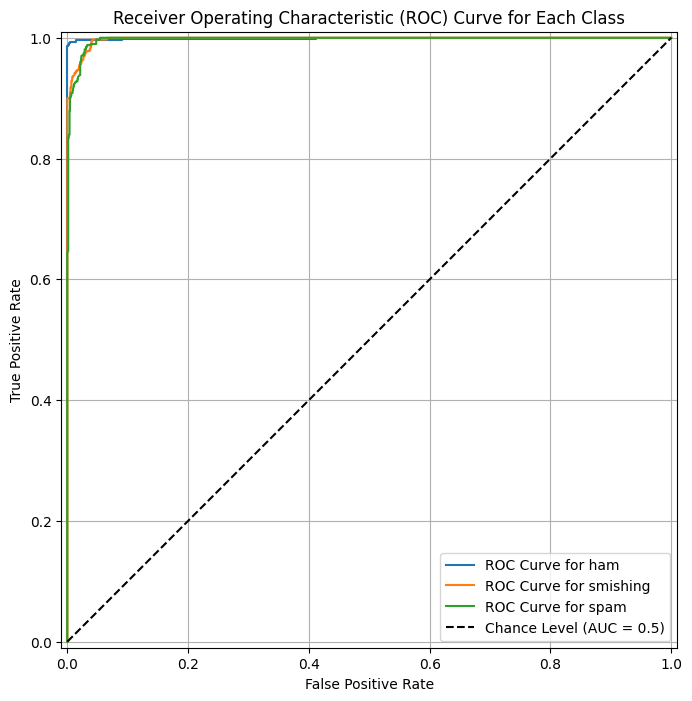

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

plt.figure(figsize=(10, 8))

# Iterate through each class to plot its ROC curve
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, i], pos_label=i)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=None, estimator_name=f'Class: {class_name}')
    roc_display.plot(ax=plt.gca(), name=f'ROC Curve for {class_name}')

plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)') # Add diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()